In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random

In [2]:
# Load data
# Filmtrust
# Build UI matrix
users = []
items = []
scores = []
with open('./filmtrust/ratings.txt') as f:
#with open('./test_dataset/debug.txt') as f:
    for l in f.readlines():
        r = l.strip().split()
        users.append(int(r[0]))
        items.append(int(r[1]))
        scores.append(float(r[2]))

In [3]:
np.unique(scores)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [4]:
UI_matrix = csr_matrix((scores, (users, items)))

## Graph Building

In [5]:
edges = []
user_nodes, item_nodes = [], [] 
max_user, max_item = 0, 0
for u, i, s in zip(users, items, scores):
    edges.append((f"U-{u}", f"I-{i}", {'s': s}))
    user_nodes.append(f"U-{u}")
    item_nodes.append(f"I-{i}")
    max_user = max(u, max_user)
    max_item = max(i, max_item)

user_nodes = np.unique(user_nodes)
item_nodes = np.unique(item_nodes)
print(f"user range [1-{max_user}]")
print(f"item range [1-{max_item}]")

user range [1-1508]
item range [1-2071]


In [6]:
G_source = nx.Graph(edges)

In [7]:
print(len(G_source.edges))

35494


## Algorithm Implementation

### Meta-path building

In [8]:
def meta_path_edges(G, rate_range):
    edge_dict = dict()
    for i in tqdm(item_nodes):
        adjacent_users = [u[0] for u in G.adj[i].items() if u[1]['s'] in rate_range]
        adjacent_users = sorted(adjacent_users, reverse=True)
        for j in range(len(adjacent_users)):
            u1 = adjacent_users[j]
            for k in range(j + 1, len(adjacent_users)):
                u2 = adjacent_users[k]
                if not edge_dict.get((u1, u2)): edge_dict[(u1, u2)] = 1
                else: edge_dict[(u1, u2)] += 1
    return edge_dict

def merge_metapaths(*args):
    P_edge_dict = args[0].copy()
    for edge_dict in args[1:]:
        for e in edge_dict:
            if P_edge_dict.get(e): P_edge_dict[e] += edge_dict[e]
            else: P_edge_dict[e] = edge_dict[e]
    return P_edge_dict

def normalize_edge_dict(edge_dict, mode='minmax', range_=[0, 1]):
    if mode == 'minmax':
        min_, max_ = np.min(list(edge_dict.values())), np.max(list(edge_dict.values()))
        for e in edge_dict:
            edge_dict[e] = range_[0] + (((edge_dict[e] - min_) * (range_[1] - range_[0])) / (max_ - min_))
            # edge_dict[e] = 2 * ((edge_dict[e] - min_) / (max_ - min_)) - 1
    else:
        raise NotImplementedError
    return edge_dict

Create Metapath Networks (it only return edges)

In [9]:
# 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. 

P1_edge_dict = meta_path_edges(G_source, [0.5, 1.0, 1.5])
P2_edge_dict = meta_path_edges(G_source, [2.0,2.5, 3.0])
P3_edge_dict = meta_path_edges(G_source, [3.5, 4.0])

100%|██████████| 2071/2071 [00:00<00:00, 2758.16it/s]


Add metapaths to build the U-U matrix (it actually creates de U-U edgelist)

In [10]:
P_edge_dict = merge_metapaths(P1_edge_dict, P2_edge_dict, P3_edge_dict) # Join metapaths for U-U matrix

<Axes: ylabel='Count'>

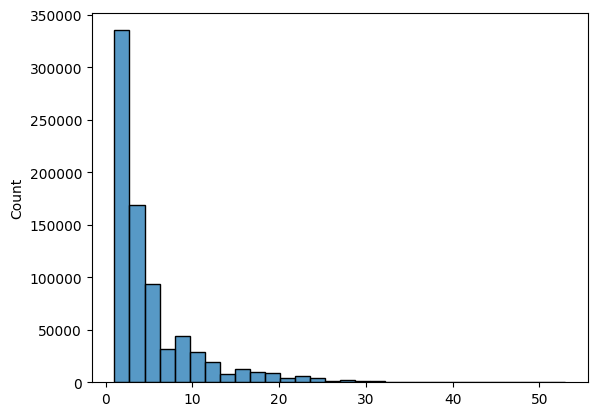

In [11]:
P_edge_weights = list(P_edge_dict.values())
sns.histplot(P_edge_weights, bins=30)

Most of the edge weights in the U-U matrix leans towards zero. The users that share items with similar ratings usually do it in a few movies.

In [12]:
P_edge_dict_norm = normalize_edge_dict(P_edge_dict.copy(), range_=[-1, 1]) # Normalize(minmax)
S_main = nx.Graph([(k[0], k[1], {'s': v}) for k, v, in P_edge_dict_norm.items()]) # Buld S_main graph

In [13]:
print("User-User Network Description")
print("Nodes:", S_main.number_of_nodes(), "Edges:", S_main.number_of_edges())

User-User Network Description
Nodes: 1498 Edges: 783458


In [14]:
def draw_G(G):
    pos = nx.spring_layout(G, seed=7)
    
    nx.draw(G, pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(G, 's')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

#plt.figure(figsize=(2,2))
#draw_G(S_main)
#nx.draw(S_main)

Scaling this poses a set of issues regarding the link prediction technique proposed by the authors of the paper. Using WAA (Weighted Adamic-Adar) for link prediction, and taking into account that most of our edges are negative means that we won't be able to calculate the weight due to the logarithm used.

<Axes: ylabel='Count'>

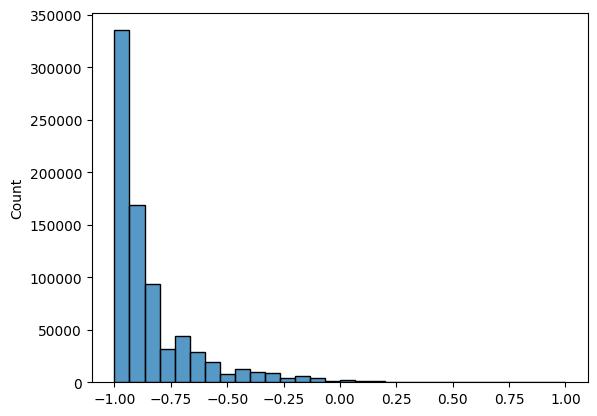

In [15]:
uu_edges = [(s, t, v['s'])for s, t, v in S_main.edges(data=True)]
uu_edge_weights = [i[2] for i in uu_edges]
sns.histplot(uu_edge_weights, bins=30)

### Link Prediction on U-U
Here we use the Weighted Adamic Adar (WAA) formula provided by the authors

$$score(u,v) = \sum_{z\in\Gamma(u)\cap\Gamma(v)}\frac{W(u,z) + W(v,z)}{2log(\sum_{z'\in\Gamma(z)}W(z,z'))}$$

* $u, v$: Users
* $\Gamma(u)$: Neighbors of $u$ in the network
* $W(u,v)$: Similarity between u and v as the weights of the link network
* $\Gamma(u)\cap\Gamma(v)$: Set of common neighbors of u and v

In [16]:
# Define lambda function to get weight from any graph
W = lambda G, u, v: G.get_edge_data(u, v, {'s': 0})['s']
print(W(S_main, 'U-1', 'U-2'))
print(W(S_main, 'U-1', 'U-4'))

# Use nx.common_neighbors(G, u, v) for the set of common neighbors between u and v
# Use nx.neighbors(G, u) or G.neighbors(u) for the set of neighbors of u

0
-1.0


In [17]:
# Weighted adamic-adar
def weighted_adamic_adar(G, u, v):
    sum_ = 0
    for z in nx.common_neighbors(G, u, v):
        sub_sum = (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))
        if np.isnan(sub_sum): sum_ += 0
        else: sum_ += sub_sum
    return sum_

# Testing
weighted_adamic_adar(S_main, 'U-1', 'U-3')

/tmp/ipykernel_47224/1453345246.py:5: RuntimeWarning: invalid value encountered in log
  sub_sum = (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))


0

Note that the authors didn't provided an explanation on what happens when the logarithm is negative or zero. In that case we asume that the same thing happens as in the adamic addar index when the nodes have no common neighbors

In [18]:
S_e = nx.Graph()
S_users = list(S_main.nodes)
for i in tqdm(range(len(S_users)), total=len(S_users)):
    for j in tqdm(range(i + 1, len(S_users))):
        u, v = S_users[i], S_users[j]
        if (W(S_main, u, v) is None or W(S_main, u, v) == 0.0) and u != v:
            waa = weighted_adamic_adar(S_main, u, v)
            if waa == 0: continue
            S_e.add_edge(u, v, s=waa)

  0%|          | 0/1498 [00:00<?, ?it/s]/tmp/ipykernel_47224/1453345246.py:5: RuntimeWarning: invalid value encountered in log
  sub_sum = (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))
  0%|          | 3/1498 [02:03<17:02:47, 41.05s/it]


KeyboardInterrupt: 

In [ ]:
# Update S_e with original edges
S_e.add_weighted_edges_from([(*x[0], x[1]) for x in nx.get_edge_attributes(S_main, 's').items()], 's')

We stopped the execution because this method is quite slow and has the limitations mentioned before. Our aim in this case is trying to use this U-U matrix we already generated, but change the way we generate new links between users using methods based on node2vec. Here is an example: https://keras.io/examples/graph/node2vec_movielens/ . 

In said example they build an Item-Item matrix using the mutual information given by the user's ratings, and use node2vec to generate embeddings of the movies (items) and extract similar movies to a given movie.

In our case, we want to use the U-U matrix we have already built to generate user embeddings and use cosine distance to determine if two users should be linked.

> As a caveat, we are aware that the node2vec approach does not work well with unseen data (i.e. a new node is added to the network), but our aim is not to fix cold-start related problems, but to explore alternatives to what the authors proposed usin WAA

 ### Node2Vec Approach

In [19]:
# Recompute the U-U graph
P_edge_dict_norm = normalize_edge_dict(P_edge_dict.copy(), range_=[0.0001, 1]) # Normalize(minmax [0, 1])
S_main = nx.Graph([(int(k[0][2:]), int(k[1][2:]), {'s': v}) for k, v, in P_edge_dict_norm.items()]) # Buld S_main graph

In [20]:
vocabulary = list(S_main.nodes())
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

Note that we removed the 'U-' suffix from the users becase S_main is the U-U network and we no longer need to differentiate between users and items. On the other hand, we changed the scaling to keep the weights between 0 and 1.

#### Random Walk
We perform random walks in order to randomly pick a sample of nodes that will work as the neighborhood of the source node in order to train the node2vec algorithm. The variant we implemented is called **biased random walk**, which balances between taking node samples in depth (dfs) or local neighbours (bfs). This is controlled by the following parameters:
* Return parameter $p$: controls how likely it is to immediately revisit a node we just visited. A high value encourages exploration.
* In-Out parameter $q$: controls how likely it is to stay in the neighborhood of a node. A high value biases the random walk towards local nodes.
> node2vec and **biased random walk** explained: https://memgraph.com/blog/how-node2vec-works

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import defaultdict

2023-04-19 00:54:42.077179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 00:54:42.103647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 00:54:42.104180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 00:54:42.771723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [49]:
import tensorflow as tf

print(f'\nTensorflow version = {tf.__version__}\n')
print(f'\n{tf.config.list_physical_devices("GPU")}\n')


Tensorflow version = 2.12.0


[]



In [50]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [29]:
def next_step(G, previous, current, p, q):
    neighbors = list(G.neighbors(current))
    
    # Dinamically define the transition probabilities given the current node and its in/out edge weights
    weights = []
    for neighbor in neighbors:
        if neighbor == previous:
            weights.append(G[current][neighbor]['s'] / p) # Return probability
        elif G.has_edge(neighbor, previous):
            weights.append(G[current][neighbor]['s']) # Probability of visiting local node
        else:
            weights.append(G[current][neighbor]['s'] / q) # Forward probability
    # Noramlize weights
    weights_sum = sum(weights)
    probabilities = [w / weights_sum for w in weights]
    next_node = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next_node

def random_walk(G, num_walks, num_steps, p, q):
    walks = []
    nodes = list(G.nodes())
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)
        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration{walk_iteration + 1} of {num_walks}"
        ):
            walk = [node]
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(G, previous, current, p, q)
                walk.append(next)
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)
    return walks

In [40]:
p=1
q=1
num_walks = 10
num_steps = 10
walks = random_walk(S_main, num_walks, num_steps, p, q)

Random walks iteration10 of 10: 100%|██████████| 1498/1498 [00:27<00:00, 55.42it/s]


#### Generate examples
To train the skipgram model we use the walks to generate positive and negative training examples.
* **target:** An user in the walk sequence.
* **context:** Another user in the walk sequence.
* **weight:** How many times these two users occurred in walk sequences.
* **label:** 1 if both users are samples from walk sequences, otherwise 0

In [41]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)


Generating postive and negative examples: 100%|██████████| 14980/14980 [00:13<00:00, 1095.50it/s]


In [42]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (1397880,)
Contexts shape: (1397880,)
Labels shape: (1397880,)
Weights shape: (1397880,)


In [43]:
batch_size = 1024
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

#### Training

In [44]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [45]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

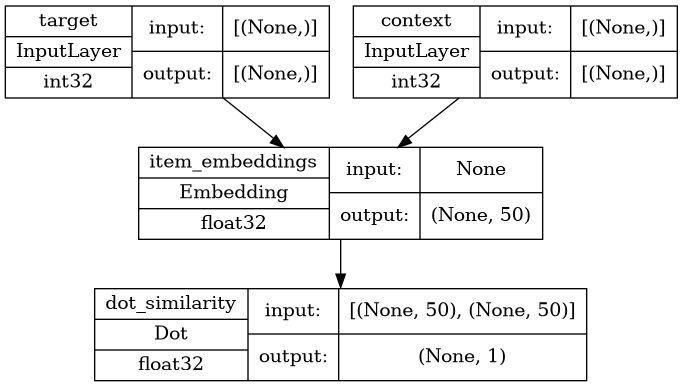

In [46]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [47]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10


2023-04-19 00:12:17.995759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1397880]
	 [[{{node Placeholder/_3}}]]
2023-04-19 00:12:17.996218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1397880]
	 [[{{node Placeholder/_3}}]]


1365/1365 [==============================] - 14s 10ms/step - loss: 3.2450
Epoch 2/10
1365/1365 [==============================] - 13s 10ms/step - loss: 3.2478
Epoch 3/10
1365/1365 [==============================] - 14s 10ms/step - loss: 3.2269
Epoch 4/10
1365/1365 [==============================] - 13s 10ms/step - loss: 3.2257
Epoch 5/10
1365/1365 [==============================] - 14s 10ms/step - loss: 3.2247
Epoch 6/10
1365/1365 [==============================] - 14s 10ms/step - loss: 3.2239
Epoch 7/10
1365/1365 [==============================] - 12s 9ms/step - loss: 3.2232
Epoch 8/10
1365/1365 [==============================] - 12s 9ms/step - loss: 3.2222
Epoch 9/10
1365/1365 [==============================] - 12s 9ms/step - loss: 3.2214
Epoch 10/10
1365/1365 [==============================] - 12s 9ms/step - loss: 3.2203


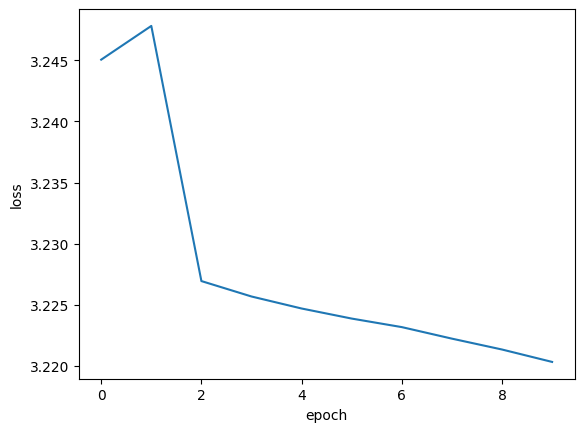

In [48]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

### Information Enhancing

> WIP - Work In Progress

In [276]:
u = "U-999"
i = "I-10"
#positive_neighbors = 

In [277]:
# sorted([u[0] for u in G.adj[i].items() if u[1]['s'] in rate_range], reverse=True)
[v[0] for v in S_e.adj[u].items() if v[1].get('s', -1) > 0]

[]

In [266]:
for v in S_e.adj[u].items():
    print(v[1]['s'])
    break

-25.597641665166538


In [289]:
[(e[0], e[1], e[2]) for e in S_e.edges(data='s')]

[('U-999', 'U-957', -14.608894399254318),
 ('U-999', 'U-847', -26.26600851934535),
 ('U-999', 'U-839', -15.84320764259906),
 ('U-999', 'U-790', -33.79467822853215),
 ('U-999', 'U-752', -14.589114749735897),
 ('U-999', 'U-69', -7.006972362763672),
 ('U-999', 'U-608', -23.626686127740953),
 ('U-999', 'U-590', -25.976172133500782),
 ('U-999', 'U-562', -18.47293792349786),
 ('U-999', 'U-56', -14.00986829606851),
 ('U-999', 'U-521', -7.006972362763672),
 ('U-999', 'U-393', -11.887884693679021),
 ('U-999', 'U-364', -7.006972362763672),
 ('U-999', 'U-362', -16.434574021294576),
 ('U-999', 'U-357', -7.006972362763672),
 ('U-999', 'U-306', -7.006972362763672),
 ('U-999', 'U-259', -11.790204122622596),
 ('U-999', 'U-232', -20.56693737628288),
 ('U-999', 'U-223', -24.567197538540384),
 ('U-999', 'U-198', -18.006808892763157),
 ('U-999', 'U-175', -13.816332427346524),
 ('U-999', 'U-1496', -15.170247398775706),
 ('U-999', 'U-1478', -26.699656238715363),
 ('U-999', 'U-1461', -22.689042842875164),
 (